<a href="https://colab.research.google.com/github/PhilipOe1612340/CVIS_DeepLearning/blob/master/exercises_01/ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/PhilipOe1612340/CVIS_DeepLearning.git
!pip install pillow
!pip install imageio

Cloning into 'CVIS_DeepLearning'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 2), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [0]:
import imageio as imageIO

import numpy as np
#from scipy.misc import imresize
import matplotlib.pyplot as plt
import code

In [0]:
import glob
# find images in exercise 1
base_images = []
vignet_images = []

for path in glob.iglob("CVIS_DeepLearning/exercises_01/**/cat_*.jpg", recursive=True):
  if "vignetted" in path:
    vignet_images.append(path)
  else:
    base_images.append(path)
  
vignet_images.sort()
base_images.sort()

In [0]:
def vignetting( I ):

    a0 = 1.0
    a1 = -0.3
    a2 = 0.05
    a3 = -0.25
    a4 = -0.4
    a5 = -0.05
    a6 = 0.1
    
    # compute vignetting factor on complete grid
    W = I.shape[1]
    H = I.shape[0]
    wc = W/2
    hc = H/2
    
    xv,yv = np.meshgrid( np.arange( W ) - wc, np.arange( H ) - hc)
    
    r = np.sqrt( xv ** 2 + yv ** 2 ) / np.sqrt( wc**2 + hc**2 )
    s = a0 + a1*r + a2* (r **2 ) + a3 * (r ** 3) + a4 * (r ** 4) + a5 * (r**5) + a6 * (r**6) # and so on
    
    #code.interact( local=locals() )
    
    J = np.zeros( I.shape, np.float32 )
    J[ :,:,0 ] = s * I[ :,:,0 ]
    J[ :,:,1 ] = s * I[ :,:,1 ]
    J[ :,:,2 ] = s * I[ :,:,2 ]
    return J

In [0]:

def imgVector(image):
  img_temp = image[:,:,0]
  img_temp = img_temp.reshape(img_temp.shape[0]*img_temp.shape[1],1)

  img_temp2 = image[:,:,1]
  img_temp2 = img_temp2.reshape(img_temp2.shape[0]*img_temp2.shape[1],1)

  img_temp3 = image[:,:,2]
  img_temp3 = img_temp3.reshape(img_temp3.shape[0]*img_temp3.shape[1],1)

  img_copy_RGB = np.append(img_temp,img_temp2)
  img_copy_RGB = np.append(img_copy_RGB,img_temp3)
  #print(img_copy_RGB.shape[0])
  img_copy_RGB = img_copy_RGB.reshape(img_copy_RGB.shape[0],1)
  

  W = image.shape[1]
  H = image.shape[0]
  wc = W/2
  hc = H/2
  
  xv,yv = np.meshgrid( np.arange( W ) - wc, np.arange( H ) - hc)
  
  r = np.sqrt( xv ** 2 + yv ** 2 ) / np.sqrt( wc**2 + hc**2 )
  r = r.reshape(r.shape[0]*r.shape[1],1)
  #print(r.shape)
  return img_copy_RGB, r

In [22]:
import tensorflow as tf

In [0]:
N=4
M=1


X-Input preparation

In [19]:

imgX = imageIO.imread(base_images[0])

img_vignetted = vignetting( imgX )

img_copy, r = imgVector(imgX)

print(img_copy)
#img_copy=img_copy.reshape(width*height,1)
#img_vignetted_copy = img_vignetted
#img_vignetted_copy=img_vignetted_copy.reshape(width*height,1)

[[ 97]
 [131]
 [139]
 ...
 [ 93]
 [ 82]
 [ 83]]


In [36]:
r_withExponent = r
img_copyExtended = img_copy
#print(img_copy.shape)
for i in range(1,N):
  r_withExponent = np.append(r_withExponent, (r**i),axis=1)
  img_copyExtended = np.append(img_copyExtended, img_copy, axis=1)
#print(r_withExponent)
r_withExponent_temp = np.append(r_withExponent,r_withExponent,axis=0)
r_withExponent_temp = np.append(r_withExponent_temp,r_withExponent,axis=0)
r_withExponent = r_withExponent_temp
X_input = img_copyExtended * r_withExponent
print(X_input)

[[ 97.          97.          97.          97.        ]
 [130.76487151 130.76487151 130.53016504 130.29587985]
 [138.50217922 138.50217922 138.00614135 137.51188002]
 ...
 [ 92.23299319  92.23299319  91.47231219  90.71790481]
 [ 81.46995247  81.46995247  80.94333116  80.42011393]
 [ 82.61220327  82.61220327  82.22621843  81.842037  ]]


Y-Ground truth

In [37]:
imgY = imageIO.imread(vignet_images[0])
img_Y,_  = imgVector(imgY)
img_Y=img_Y/255
print(img_Y)
img_Y=img_Y*255
print(img_Y)

[[0.1372549 ]
 [0.06666667]
 [0.15686275]
 ...
 [0.11372549]
 [0.09803922]
 [0.03529412]]
[[35.]
 [17.]
 [40.]
 ...
 [29.]
 [25.]
 [ 9.]]


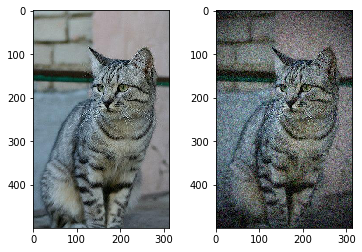

In [38]:
plt.subplot(1, 2, 1)
plt.imshow(imgX)

# Show the tinted image
plt.subplot(1, 2, 2)

# A slight gotcha with imshow is that it might give strange results
# if presented with data that is not uint8. To work around this, we
# explicitly cast the image to uint8 before displaying it.
plt.imshow(imgY)
plt.show()

Build up of Tensorflow

In [0]:
X = tf .placeholder(tf.float32,[None,N], name='input')

Y = tf.placeholder(tf.float32,[None,1],name='targets')
Y = tf.convert_to_tensor(img_Y, np.float32)

In [41]:
with tf.variable_scope( 'model'):
  W = tf.get_variable( name= 'W', shape =[N,M] ,
    dtype= tf.float32 )
  print(W.name)

model/W:0


In [0]:
#with tf.variable_scope( 'model' , reuse=True ):
#  W2 = tf.get_variable( name= 'W')
#  assert( W==W2 )

In [0]:
#with tf.variable_scope( 'model' ):
#  W = tf.get_variable( name= 'W' , shape=[M,N] ,dtype= tf.float32 )
#  print ( W.name ) # ” / model /W: 0 ”
#  with tf.variable_scope( 'layer1' ):
#    W = tf.get_variable( name= 'W' , shape =[M,N] ,dtype= tf.float32 )
#    print ( W.name )

In [43]:
tf.trainable_variables()
tf.global_variables()

[<tf.Variable 'model/W:0' shape=(4, 1) dtype=float32_ref>]

In [0]:
X_times_W = tf.matmul(X,W)
b = tf.get_variable(name= 'bias', dtype =tf.float32 , shape=[1] )
Y_pred = X_times_W + b

In [0]:
sess = tf.InteractiveSession()
gvi = tf.global_variables_initializer()
gvi.run(session = sess)

In [0]:
#X_in =tf.convert_to_tensor(X_input, np.float32)
X_in = X_input
#print(np.random.randn( 100 , N ))
feed_dict = { X: X_in}

In [0]:
eval_Y , eval_b = sess.run ( [Y, b ] , feed_dict = feed_dict )

In [0]:
optimizer = tf.train.GradientDescentOptimizer ( 1e-4 )

In [49]:
loss = tf.losses.mean_squared_error ( Y, Y_pred )
minimizer_step = optimizer.minimize ( loss )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#X_train = np.random.randn( 100 , N )
#X_train =tf.convert_to_tensor(X_input, np.float32)
#print(X_train)
#Y_train = np.random.randn( 100 )
#Y_train = tf.convert_to_tensor(img_Y , np.float32)
X_train =X_input
Y_train = img_Y

In [51]:
feed_dict2 = {X:X_train , Y:Y_train}
print(X_train.dtype)
print(Y_train.shape)

float64
(469500, 1)


In [52]:
while True:
  sess.run(minimizer_step,feed_dict=feed_dict2)
  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-1fac6b312dad>", line 2, in <module>
    sess.run(minimizer_step,feed_dict=feed_dict2)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 956, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1180, in _run
    feed_dict_tensor, options, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1359, in _do_run
    run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1365, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1350, in _run_fn
    target_list, run_metadata)
  Fi

KeyboardInterrupt: ignored